In [3]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [4]:
# Defining path
path = r'C:\Users\15618\Instacart Basket Analysis'

In [5]:
# import data
df_complete_data = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'df_merged_final.pkl'))

In [22]:
df_departments = pd.read_csv(os.path.join(path, '02 Data', 'prepared Data', 'departments_wrangled.csv'))

In [5]:
df_complete_data.shape

(32434212, 36)

In [6]:
df_complete_data.head()

Unnamed: 0_x  product_id                product_name  aisle_id  \
0             0           1  Chocolate Sandwich Cookies        61   
1             0           1  Chocolate Sandwich Cookies        61   
2           907         907        Premium Sliced Bacon       106   
3           907         907        Premium Sliced Bacon       106   
4          1000        1000                    Apricots        18   

   department_id  prices  Unnamed: 0_y  order_id  user_id eval_set  ...  \
0             19     5.8          1987   3139998      138    prior  ...   
1             19     5.8          1989   1977647      138    prior  ...   
2             12    20.0          1960   3160996      138    prior  ...   
3             12    20.0          1969   2254091      138    prior  ...   
4             10    12.9          1968    505689      138    prior  ...   

      frequency_flag  first_name  last_name  gender      STATE  age  \
0  Frequent customer     Charles        Cox    Male  Minnesota   81   
1  Frequent customer     Charles        Cox    Male  Minnesota   81   
2  Frequent customer     Charles        Cox    Male  Minnesota   81   
3  Frequent customer     Charles        Cox    Male  Minnesota   81   
4  Frequent customer     Charles        Cox    Male  Minnesota   81   

  date_joined no_of_dependents marital_status income  
0    8/1/2019                1        married  49620  
1    8/1/2019                1        married  49620  
2    8/1/2019                1        married  49620  
3    8/1/2019                1        married  49620  
4    8/1/2019                1        married  49620  

[5 rows x 36 columns]

In [ ]:
df_complete_data.info

In [6]:
df_complete_data.rename(columns = { 'STATE' : 'state'}, inplace =True)

# 02. PII

In [7]:
#Observing the column names in order to detect any PII data
df_complete_data.columns

Index(['Unnamed: 0_x', 'product_id', 'product_name', 'aisle_id',
       'department_id', 'prices', 'Unnamed: 0_y', 'order_id', 'user_id',
       'eval_set', 'order_number', 'orders_day_of_week', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_order', 'reordered', '_merge',
       'price_range_loc', 'busiest_day', 'Busiest days',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'spender_flag', 'median_days_since_prior_order', 'frequency_flag',
       'first_name', 'last_name', 'gender', 'STATE', 'age', 'date_joined',
       'no_of_dependents', 'marital_status', 'income'],
      dtype='object')

In [11]:
df_complete_data = df_complete_data.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y', 'first_name', 'last_name', 'eval_set'])

first name and last name contain PII so they were removed. also removed extra clutter

# 03. Regions

In [7]:
# list of regions 
northeast=['Vermont','New Hampshire','Maine','Massachusetts','Rhode Island','Connecticut','New Jersey','Pennsylvania','New York']
midwest=['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota','Nebraska','Kansas','Minnesota','Iowa','Missouri']
south=['Delaware','Maryland','District of Columbia','Virginia','West Virginia','North Carolina','South Carolina','Georgia','Florida','Kentucky', 'Tennessee','Mississippi','Alabama','Oklahoma','Texas','Arkansas','Louisiana']
west=['Idaho','Montana','Wyoming','Nevada','Alaska','Colorado','Arizona','New Mexico','Utah','Washington','Oregon','California','Hawaii']

In [8]:
# regional flags
df_complete_data.loc[df_complete_data['state'].isin(northeast), 'region']='Northeast'
df_complete_data.loc[df_complete_data['state'].isin(south), 'region']='South'
df_complete_data.loc[df_complete_data['state'].isin(midwest), 'region']='Midwest'
df_complete_data.loc[df_complete_data['state'].isin(west), 'region']='West'

In [9]:
# Crossing with spending flag
crosstab=pd.crosstab(df_complete_data['region'], df_complete_data['frequency_flag'],  dropna=False)
crosstab

frequency_flag  Frequent customer  Non-frequent customer  Regular customer
region                                                                    
Midwest                   5021707                 864278           1717825
Northeast                 3807551                 630798           1289998
South                     7198077                1216060           2387473
West                      5550074                 928533           1821838

In [18]:
# states per region
df_complete_data.groupby('region')['state'].nunique()

region
Midwest      12
Northeast     9
South        17
West         13
Name: state, dtype: int64

due to there being more stgates located in the south region, naturally there are more customers there and more revenue is made there.

# 04. excluding low-activity customers

In [13]:
# Creating exclusion flag for low-activity customers
df_complete_data.loc[df_complete_data['max_order']>=5, 'activity']='1'
df_complete_data.loc[df_complete_data['max_order']<5, 'activity']='0'

In [14]:
df_complete_data['activity'].value_counts(dropna=False)

1    30992664
0     1441548
Name: activity, dtype: int64

In [17]:
#Reducing memory issues
df_complete_data['activity']=df_complete_data['activity'].astype('int8')

In [18]:
# Creating a dataset with inactive customers
inactive_customers=df_complete_data[df_complete_data['activity']==0]

In [19]:
#Exporting the dataset of inactive customers
inactive_customers.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'inactive_customers.pkl'))

In [20]:
# Deleting inactive_customers since no longer needed
del inactive_customers

In [22]:
# Creating a dataset of active customers
df_actives = df_complete_data[df_complete_data['activity']==1]

In [24]:
# Deleting main data frame since no longer needed and memory problems 
del df_complete_data

# 05. profiles

In [27]:
# Creating age profile for young adults 18-30, middle-aged adults 31-55, older adults:56+ years
df_actives.loc[df_actives['age']<=30, 'age_group']='young'
df_actives.loc[(df_actives['age']<=55)&(df_actives['age']>31), 'age_group']='middle'
df_actives.loc[df_actives['age']>55, 'age_group']='older'
df_actives['age_group'].value_counts(dropna=False)

older     12519636
middle    11656291
young      6310113
NaN         506624
Name: age_group, dtype: int64

In [29]:
# Creating income profiles: less than 55,000 = low income, greater than 120,000 = high income
df_actives.loc[df_actives['income']<55000, 'income_group']='low income'
df_actives.loc[(df_actives['income']>=56000)&(df_actives['income']<120000), 'income_group']='middle income'
df_actives.loc[df_actives['income']>120000, 'income_group']='high income'
df_actives['income_group'].value_counts(dropna=False)        

C:\Users\15618\AppData\Local\Temp\ipykernel_15592\116927893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives.loc[df_actives['income']<55000, 'income_group']='low income'


middle income    17075524
high income       9187363
low income        4456970
NaN                272807
Name: income_group, dtype: int64

In [32]:
# Creating profile for dependents and no dependents
df_actives.loc[df_actives['no_of_dependents']>0, 'dependant_group']='has dependents'
df_actives.loc[df_actives['no_of_dependents']==0,'dependant_group']='no dependents'
df_actives['dependant_group'].value_counts(dropna=False)

C:\Users\15618\AppData\Local\Temp\ipykernel_15592\2172812456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actives.loc[df_actives['no_of_dependents']>0, 'dependant_group']='has dependents'


has dependents    23245632
no dependents      7747032
Name: dependant_group, dtype: int64

In [ ]:
bar = df_actives['age_group'].value_counts().plot.bar()

above is a bar chart for age groups among the customers

<AxesSubplot:ylabel='Frequency'>

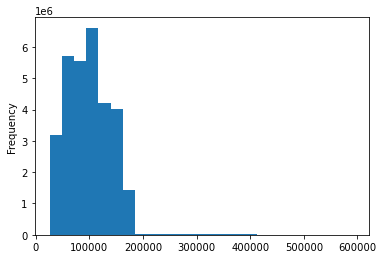

In [40]:
# histogram looking into the income of customers and the frequency of purchases
hist = df_actives['income'].plot.hist(bins=25)

In [ ]:
# Aggregating the max, min, and mean variables on age profiles
df_actives.groupby(['age_group']).agg({'median_order_days':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

In [76]:
# Aggregating the max, mean, and min variables on income profiles
df_actives.groupby(['income_group']).agg({'median_order_days':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

In [139]:
 # Aggregating the max, min, and mean variables on number of dependents profiles
df_actives.groupby(['dependant_group']).agg({'median_order_days':['mean', 'min', 'max'], 'prices':['mean', 'min', 'max']})

In [ ]:
bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'bar_age_group.png'))
hist.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'hist_income_distribution.png'))
